In [31]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

In [2]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

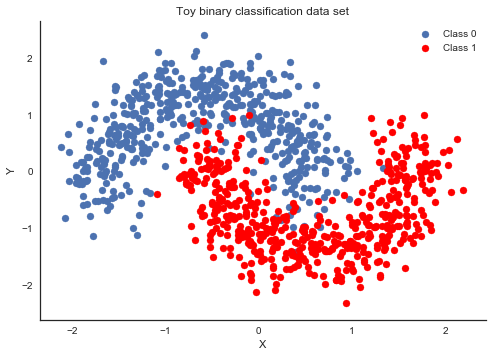

In [3]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [4]:
# Trick: Turn inputs and outputs into shared variables. 
# It's still the same thing, but we can later change the values of the shared variable 
# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input1 = theano.shared(X_train)
ann_output1 = theano.shared(Y_train)

n_hidden = 5

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)
    
with pm.Model() as neural_network1:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(X.shape[1], n_hidden), 
                             testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)
    
    # Weights from hidden lay2er to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(n_hidden,), 
                              testval=init_out)
    
    # Build neural-network using tanh activation function
    act_1 = T.tanh(T.dot(ann_input1, 
                         weights_in_1))
    act_2 = T.tanh(T.dot(act_1, 
                         weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, 
                                   weights_2_out))
    
    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=ann_output1)



/Users/kbrusch/Desktop/_notebook/lib/python2.7/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [56]:
ann_input2 = theano.shared(X_train)
ann_output2 = theano.shared(Y_train)

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)

with pm.Model() as neural_network2:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(X.shape[1], n_hidden), 
                             testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)
    
    # Weights from hidden lay2er to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(n_hidden,), 
                              testval=init_out)
    
    # Build neural-network using tanh activation function
    act_1 = T.tanh(T.dot(ann_input2, 
                         weights_in_1))
    act_2 = T.tanh(T.dot(act_1, 
                         weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, 
                                   weights_2_out))
    
    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=ann_output2)

In [52]:
%%time

with neural_network1:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = pm.variational.advi(n=100000)

Average ELBO = -194.6: 100%|██████████| 100000/100000 [00:33<00:00, 3017.62it/s]
Finished [100%]: Average ELBO = -194.27


CPU times: user 34.3 s, sys: 320 ms, total: 34.6 s
Wall time: 34.6 s


In [71]:
with neural_network2:
    # 100%|██████████| 1000/1000 [00:01<00:00, 747.11it/s]
    trace = pm.sample(1000, step=pm.Metropolis())

100%|██████████| 1000/1000 [00:01<00:00, 600.33it/s]


In [29]:
with neural_network2:
    #5%|▌         | 50/1000 [01:58<35:45,  2.26s/it]  
    pm.sample(100, step=pm.NUTS())

 43%|████▎     | 43/100 [01:37<02:12,  2.33s/it]

In [41]:
with neural_network2:
    #100%|██████████| 500/500 [00:10<00:00, 45.95it/s]
    pm.sample(1000, step=pm.Slice())


100%|██████████| 1000/1000 [00:24<00:00, 40.72it/s]


In [82]:
with neural_network2:
    #100%|██████████| 1000/1000 [00:07<00:00, 142.81it/s]
    trace = pm.sample(10000, step=pm.HamiltonianMC())


100%|██████████| 10000/10000 [01:16<00:00, 130.82it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f8f9350>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11ff64650>]], dtype=object)

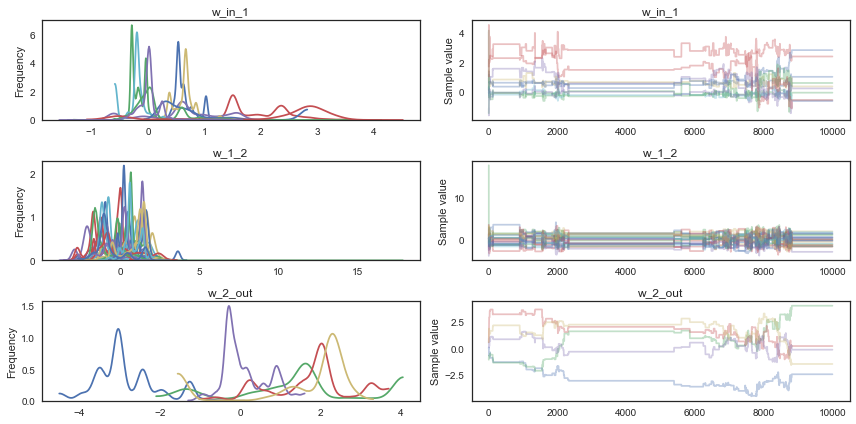

In [89]:
pm.traceplot(trace)

In [78]:
with neural_network1:
    trace = pm.variational.sample_vp(v_params, draws=5001)

100%|██████████| 5001/5001 [00:00<00:00, 9198.36it/s]


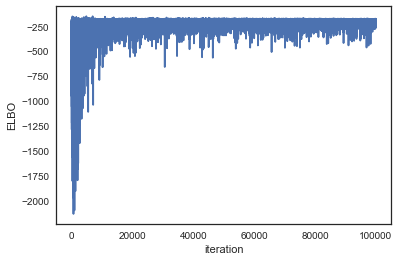

In [53]:
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration')

In [84]:
# Replace shared variables with testing set
ann_input1.set_value(X_test)
ann_output1.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network1, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

100%|██████████| 500/500 [00:03<00:00, 135.14it/s]


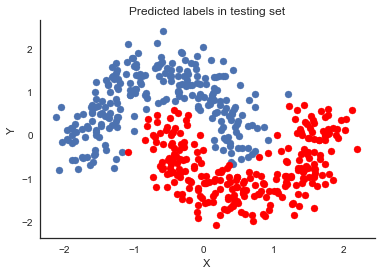

In [85]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [86]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 97.4%


In [65]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
X, Y = grid
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [68]:
ann_input1.set_value(grid_2d)
ann_output1.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network1, samples=500)

100%|██████████| 500/500 [00:05<00:00, 90.13it/s]


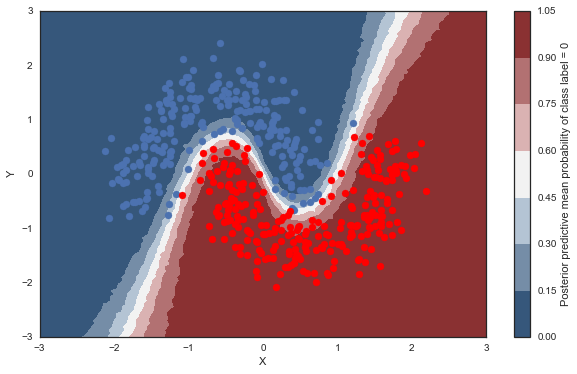

In [69]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X, Y, ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

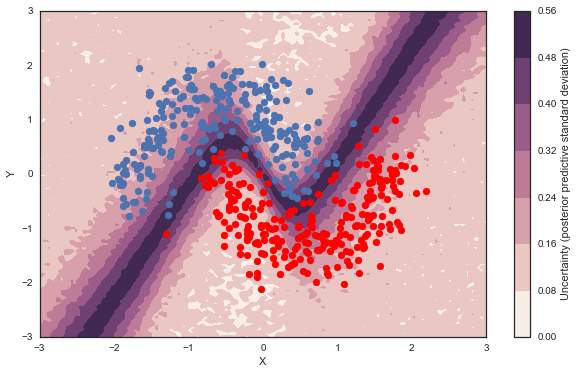

In [16]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X, Y, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

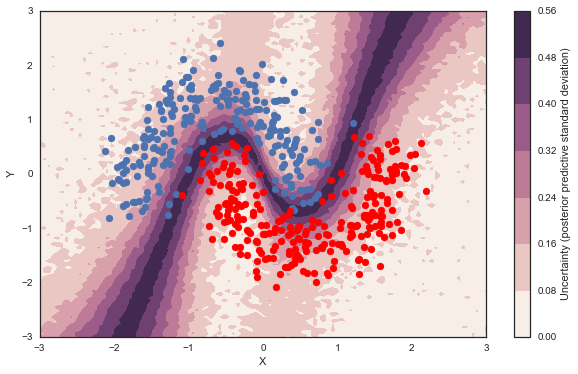

In [70]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X, Y, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [17]:
from six.moves import zip

# Set back to original data to retrain
ann_input.set_value(X_train)
ann_output.set_value(Y_train)

# Tensors and RV that will be using mini-batches
minibatch_tensors = [ann_input, ann_output]
minibatch_RVs = [out]

# Generator that returns mini-batches in each iteration
def create_minibatch(data):
    rng = np.random.RandomState(0)
    
    while True:
        # Return random data samples of set size 100 each iteration
        ixs = rng.randint(len(data), size=50)
        yield data[ixs]

minibatches = zip(
    create_minibatch(X_train), 
    create_minibatch(Y_train),
)

total_size = len(Y_train)

In [18]:
%%time

with neural_network:
    # Run advi_minibatch
    v_params = pm.variational.advi_minibatch(
        n=50000, minibatch_tensors=minibatch_tensors, 
        minibatch_RVs=minibatch_RVs, minibatches=minibatches, 
        total_size=total_size, learning_rate=1e-2, epsilon=1.0
    )

Average ELBO = -121.33: 100%|██████████| 50000/50000 [00:22<00:00, 2182.71it/s]
Finished minibatch ADVI: ELBO = -80.56


CPU times: user 27.4 s, sys: 1.37 s, total: 28.8 s
Wall time: 1min 19s
